In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Rutas a los datos
product_data_path = "../data/product_data.csv"
attributes_data_path = "../data/attribute_data.csv"
images_dir_path = "../data/train/images"

# Cargar datasets
product_data = pd.read_csv(product_data_path)
attributes_data = pd.read_csv(attributes_data_path)


2024-11-16 21:56:22.042081: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-16 21:56:22.046657: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-16 21:56:22.092311: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-16 21:56:22.130812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731790582.168801    3156 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731790582.17

In [2]:
from PIL import Image, UnidentifiedImageError

def load_and_preprocess_image(image_path, target_size=(160,224)):
    try:
        img = Image.open(image_path)
        img = np.array(img)
        return img
    except UnidentifiedImageError:
        print(f"Skipping invalid image: {image_path}")
        return None  
    except Exception as e:
        print(f"Error al cargar la imagen {image_path}: {e}")
        return None

In [3]:
print(product_data.head())

  cod_modelo_color cod_color des_sex des_age des_line des_fabric  \
0       83_1124642        82  Female    Kids     KIDS     TRICOT   
1       86_1215223        01  Female    Kids     KIDS      WOVEN   
2       84_1167695        70  Female    Kids     KIDS   CIRCULAR   
3       82_1108473        01  Female    Teen     KIDS      JEANS   
4       83_1137778        37    Male   Adult      MAN   CIRCULAR   

                  des_product_category des_product_aggregated_family  \
0                                 Tops        Sweaters and Cardigans   
1  Dresses, jumpsuits and Complete set         Dresses and jumpsuits   
2                                 Tops                      T-shirts   
3                              Bottoms                         Jeans   
4                                 Tops        Sweaters and Cardigans   

  des_product_family des_product_type                  des_filename  \
0            Sweater          Sweater  83_1124642_17074019-82_B.jpg   
1            Dre

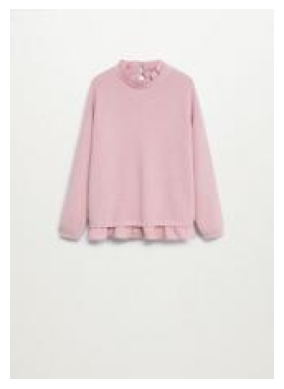

In [4]:
# Selecciona una imagen de la columna 'des_filename'
image_path = product_data['des_filename'][0]  # Por ejemplo, la primera imagen en el dataset
imagesPath = '../data/train/images/'
# Cargar y normalizar la imagen
processed_image = load_and_preprocess_image(imagesPath+image_path)

# Mostrar la imagen
plt.imshow(processed_image)
plt.axis('off')
plt.show()


In [5]:
def load_images_from_dataset(dataset, image_column):
    images = []
    imagesPath = '../data/train/images/'
    for img_path in dataset[image_column].head(1000):
        img = load_and_preprocess_image(imagesPath+img_path)
        images.append(img)
    return np.array(images)

# Cargar imágenes de todo el dataset
image_data = load_images_from_dataset(product_data, 'des_filename')

# Ver las dimensiones del array (por ejemplo, 1000 imágenes de 224x224x3)
print(image_data.shape)


(1000, 224, 160, 3)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [7]:
# Definir el modelo secuencial
model = Sequential()

# Capa convolucional 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(160, 224, 3)))
model.add(MaxPooling2D((2, 2)))

# Capa convolucional 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Capa convolucional 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Aplanar las características
model.add(Flatten())

# Capa densa 1
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout para evitar el sobreajuste

# Capa densa de salida
model.add(Dense(15, activation='softmax'))  # Usar 'sigmoid' si es clasificación binaria


/home/yasin/apaLab/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-16 21:56:40.611230: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [8]:
# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy',  # o 'binary_crossentropy' dependiendo de la tarea
              metrics=['accuracy'])


In [9]:
print(product_data.columns)

Index(['cod_modelo_color', 'cod_color', 'des_sex', 'des_age', 'des_line',
       'des_fabric', 'des_product_category', 'des_product_aggregated_family',
       'des_product_family', 'des_product_type', 'des_filename', 'des_color'],
      dtype='object')


In [10]:
import pandas as pd
import numpy as np
!pip install opencv-python
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os

# Cargar los archivos CSV

# Asegurarse de que ambas tablas estén unidas por 'cod_modelo_color'
# Obtenemos las imágenes y sus correspondientes atributos
merged_data = pd.merge(attributes_data, product_data, on='cod_modelo_color', how='left')

# Visualizar las primeras filas del dataframe combinado
print(merged_data.head())

# Establecer la ruta donde están almacenadas las imágenes
image_dir = '../data/train/images/'  # Ruta donde están las imágenes

# Preprocesar las imágenes y las etiquetas
images = []
labels = []

# Definir el tamaño de la imagen
image_size = (160, 224)  # Tamaño de imagen deseado (224x224)
for _, row in merged_data.head(1000).iterrows():
    # Cargar y redimensionar la imagen
    image_path = image_dir+ row['des_filename']
    img = cv2.imread(image_path)

    # Normalizamos la imagen (valores entre 0 y 1)
    img = img.astype('float32') / 255.0 

    images.append(img)
    
    # Guardamos la etiqueta
    labels.append(row['des_value'])

# Convertir las listas a arrays numpy
images = np.array(images)
labels = np.array(labels)

# Codificar las etiquetas de texto a valores numéricos
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Dividir los datos en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


  cod_modelo_color   attribute_name  cod_value des_value cod_color des_sex  \
0       85_1202950  silhouette_type         37      Slim        99  Female   
1       85_1202950  silhouette_type         37      Slim        99  Female   
2       86_1217677  silhouette_type         27  Oversize        95    Male   
3       86_1217677  silhouette_type         27  Oversize        95    Male   
4       84_1168477  silhouette_type         37      Slim        99  Female   

  des_age des_line des_fabric des_product_category  \
0   Adult    WOMAN     TRICOT                 Tops   
1   Adult    WOMAN     TRICOT                 Tops   
2    Teen     KIDS   CIRCULAR                 Tops   
3    Teen     KIDS   CIRCULAR                 Tops   
4   Adult    WOMAN     TRICOT                 Tops   

  des_product_aggregated_family des_product_family des_product_type  \
0                          Tops               Tops              Top   
1                          Tops               Tops              

In [11]:
#!pip install tensorflow


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definir el modelo CNN
model = models.Sequential([
    # Primera capa convolucional
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    layers.MaxPooling2D((2, 2)),
    
    # Segunda capa convolucional
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Tercera capa convolucional
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Aplanamiento
    layers.Flatten(),
    
    # Capa densa
    layers.Dense(128, activation='relu'),
    
    # Capa de salida (suponiendo que tienes un número de clases en labels_encoded)
    layers.Dense(len(np.unique(labels_encoded)), activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Resumen del modelo
model.summary()


/home/yasin/apaLab/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 158, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 79, 111, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 77, 109, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 38, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 36, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 59904)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,667,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 68)             │         8,772 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,769,860 (29.64 MB)

 Trainable params: 7,769,860 (29.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 357ms/step - accuracy: 0.0657 - loss: 4.0202 - val_accuracy: 0.1300 - val_loss: 3.5403
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 346ms/step - accuracy: 0.1462 - loss: 3.5422 - val_accuracy: 0.1300 - val_loss: 3.4455
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 346ms/step - accuracy: 0.1258 - loss: 3.4699 - val_accuracy: 0.1400 - val_loss: 3.3703
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 366ms/step - accuracy: 0.1598 - loss: 3.2614 - val_accuracy: 0.1250 - val_loss: 3.4413
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 347ms/step - accuracy: 0.2338 - loss: 3.0142 - val_accuracy: 0.1250 - val_loss: 3.6944
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 336ms/step - accuracy: 0.2755 - loss: 2.6732 - val_accuracy: 0.1150 - val_loss: 3.9463
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 333ms/step - accuracy: 0.4482 - loss: 2.1684 - val_accuracy: 0.1100 - val_loss: 4.4205
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 333ms/step - accuracy: 0.5909 - loss: 1.6373 - val_accuracy: 0

In [ ]:
# Evaluar el modelo
test_loss, test_acc = model.evaluate(X_val, y_val)
print(f"Test accuracy: {test_acc}")


50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step


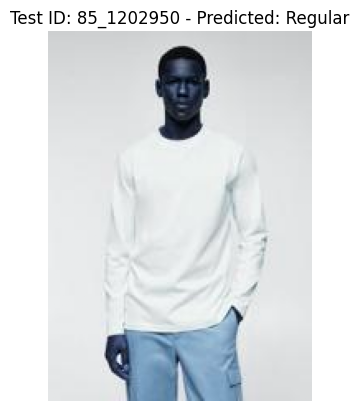

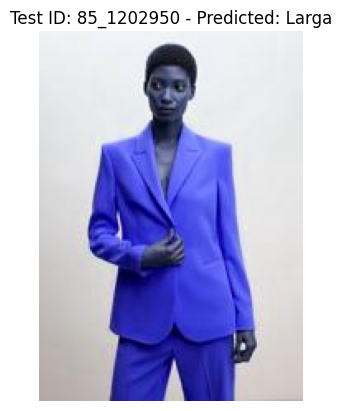

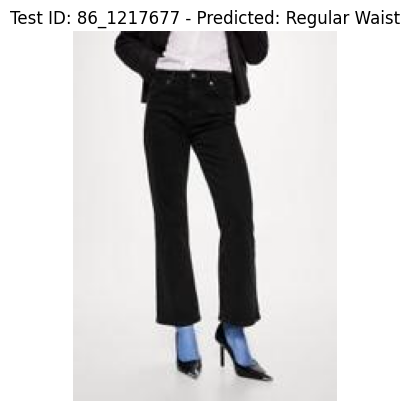

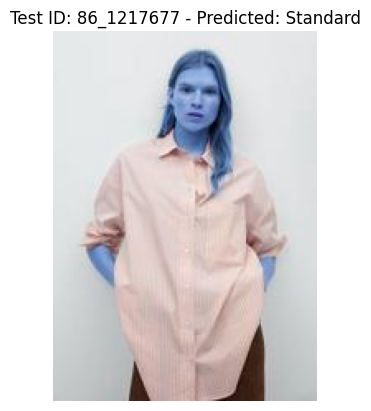

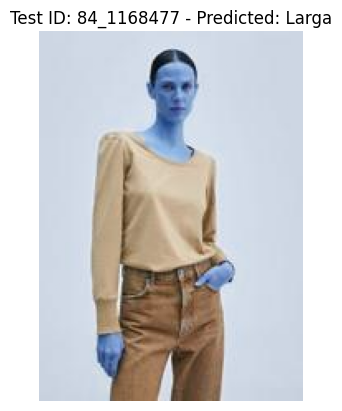

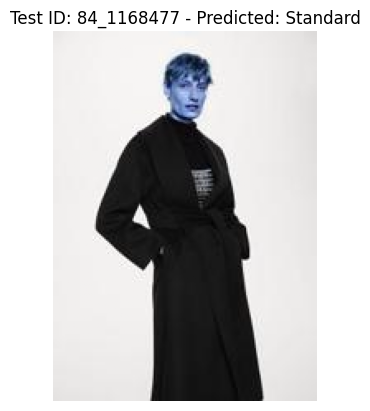

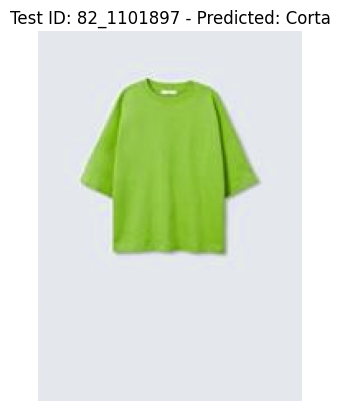

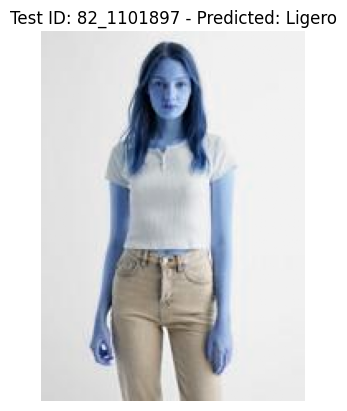

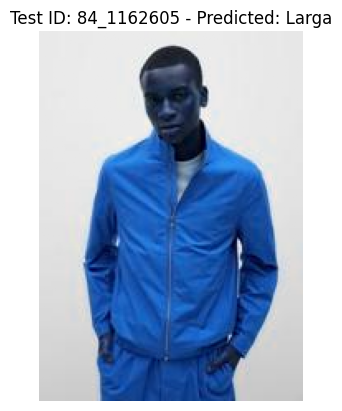

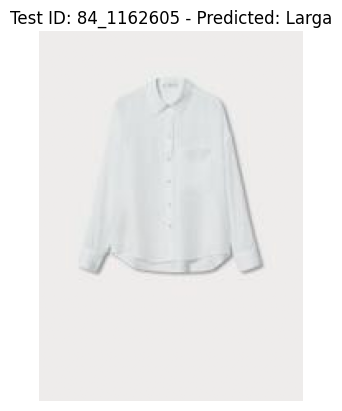

In [15]:
import matplotlib.pyplot as plt

# Obtener las predicciones del modelo (predicción de las etiquetas)
predictions = model.predict(X_val)

# Convertir las predicciones a etiquetas codificadas (números)
predicted_labels = np.argmax(predictions, axis=1)

# Convertir las etiquetas codificadas de vuelta a sus valores originales (des_value)
predicted_values = label_encoder.inverse_transform(predicted_labels)

# Obtener los identificadores de las imágenes (por ejemplo, 'test_id')
# Usamos el índice de las filas de X_val para acceder a merged_data y obtener 'cod_modelo_color'
test_ids = merged_data.iloc[:len(X_val)]['cod_modelo_color'].values  # Asegúrate de que esto esté alineado con X_val

# Visualizar algunas imágenes con sus predicciones (mostrar 5 imágenes como ejemplo)
for i in range(10):  # Muestra las primeras 5 imágenes
    plt.imshow(X_val[i])  # Mostrar la imagen
    plt.title(f"Test ID: {test_ids[i]} - Predicted: {predicted_values[i]}")  # Título con la predicción
    plt.axis('off')  # Desactivar los ejes
    plt.show()


In [ ]:
import pandas as pd

# Obtener las predicciones del modelo (predicción de las etiquetas)
predictions = model.predict(X_val)

# Convertir las predicciones a etiquetas codificadas (números)
predicted_labels = np.argmax(predictions, axis=1)

# Convertir las etiquetas codificadas de vuelta a sus valores originales (des_value)
predicted_values = label_encoder.inverse_transform(predicted_labels)

# Obtener los identificadores de las imágenes (por ejemplo, 'test_id')
# Usamos el índice de las filas de X_val para acceder a merged_data y obtener 'cod_modelo_color' y 'attribute_name'
test_ids = merged_data.iloc[:len(X_val)]['cod_modelo_color'].values
attribute_names = merged_data.iloc[:len(X_val)]['attribute_name'].values  # O la columna correspondiente en merged_data

# Crear el 'test_id' concatenando 'cod_modelo_color' y 'attribute_name'
test_ids_concat = [f"{cod_modelo_color}_{attribute_name}" for cod_modelo_color, attribute_name in zip(test_ids, attribute_names)]

# Crear un DataFrame con las predicciones
results_df = pd.DataFrame({
    'test_id': test_ids_concat,
    'des_value': predicted_values
})

# Guardar el DataFrame como un archivo CSV
results_df.to_csv('sample_submission.csv', index=False)

# Visualizar las primeras filas del DataFrame con las predicciones
print(results_df.head())
